# ROXSI 2022 SSA Nortek Signature 1000
Visualize Sig1000 data QC and statistical parameters from ROXSI 2022 Asilomar Small-Scale Array measurements.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
import cmocean
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct


In [2]:
# Functions
def contamination_range(ha, binsz=0.5, beam_angle=25):
    """
    Calculate range of velocity contamination due to sidelobe 
    reflections following Lentz et al. (2021, Jtech): 
    DOI: 10.1175/JTECH-D-21-0075.1

    According to L21 (Eq. 2), the range cells contaminated by 
    sidelobe reflections are given by
        
        z_ic < h_a * (1 - cos(theta)) + 3*dz/2,
    
    where z_ic is depth below the surface of the contaminated region
    (range cell centers), h_a is the distance from the ADCP acoustic 
    head to the surface, theta is the ADCP beam angle from the 
    vertical (25 for Sig1000) and dz is the bin size in meters. 

    Parameters:
        ha - distance from ADCP acoustic head to sea surface
        binsz - binsize in meters
        beam_angle - beam angle in degrees

    Returns:
        zic - depth below the surface of the contaminated region
    """
    zic = ha * (1 - np.cos(beam_angle)) + 3 * binsz / 2
    return zic

In [3]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103063
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory


## Read and plot bathymetry
First plot closeups of SSA bathymetry with Signature moorings marked with triangles.

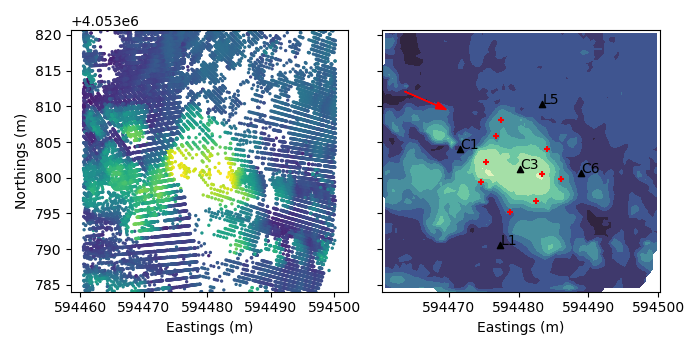

In [6]:
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2, constrained_layout=True,
                         sharey=True)
axes[0].scatter(dsb.x_pts, dsb.y_pts, c=dsb.z_pts, s=2)
axes[0].set_xlabel('Eastings (m)')
axes[0].set_ylabel('Northings (m)')
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
                 cmap=cmocean.cm.deep_r)
# Mooring locations
s = 20 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), 'C1', color='k')
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), 'C3', color='k')
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), 'C6', color='k')
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), 'L1', color='k')
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), 'L5', color='k')
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='r', s=s)

# Arrow showing 280 deg angle (typical wave direction)
x = dsb.C1_utm[0].item() - 8
y = dsb.C1_utm[1].item() + 8
r = 5
angle_met = 293 # Meteorological convention angle
angle_math = (270 - angle_met) # Convert to math conv.
if angle_math < 0:
    angle_math += 360
angle_math = np.deg2rad(angle_math)
axes[1].arrow(x, y, r*np.cos(angle_math), r*np.sin(angle_math), color='r', head_width=1)

axes[1].set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


## Plot rotated grid

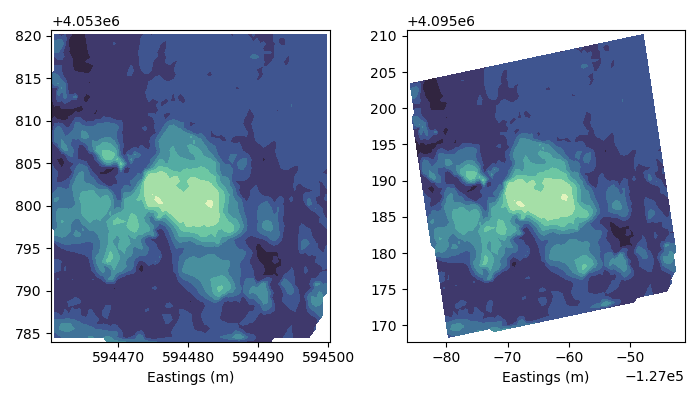

In [19]:
def mg2coords(X, Y, Z):
    return np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

def rotz(rad):
    rad = np.radians(rad)
    sin = np.sin(rad)
    cos = np.cos(rad)
    rot = [[cos, sin, 0],
            [-sin,  cos, 0],
            [0, 0, 1]]
    return np.array(rot)

fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,4), ncols=2, constrained_layout=True)

# Plot original grid
axes[0].contourf(dsb.eastings, dsb.northings, dsb.z_utm, 
                 vmin=-8.0, vmax=-3.5, cmap=cmocean.cm.deep_r)

# Rotate grid
angle_met = 293
magdec = 12.88
angle_math = 270 - angle_met + magdec
if angle_math < 0:
    angle_math += 360
xg, yg = np.meshgrid(dsb.eastings.values, dsb.northings.values)
zg = dsb.z_utm.values
xrot, yrot, zrot = rpct.rotate_zgrid(xg, yg, zg, np.radians(angle_math))
# Plot rotated grid
axes[1].contourf(xrot, yrot, zrot, vmin=-8.0, vmax=-3.5, cmap=cmocean.cm.deep_r)

for ax in axes:
    ax.set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


In [20]:
zrot

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -6.68832118, -6.61890903, ...,         nan,
                nan,         nan],
       [        nan, -6.53769844, -6.39319406, ...,         nan,
                nan,         nan],
       ...,
       [        nan, -6.55751254, -6.54077332, ..., -6.60055202,
        -6.74487727,         nan],
       [        nan, -6.67846481, -7.03436903, ..., -6.60241185,
        -6.69823658,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [19]:
dsb.z_utm.values.shape
# xg.shape
# yg.shape

(71, 81)

## Read Level 1 velocity data
If visualizing all dates, concatenate daily netcdf files into one xr.Dataset.

In [4]:
# Use all available serial numbers
sers = ['103088', '103094', '103063'] #, '103206', '103110', ]
mids = ['C1', 'C3', 'L1'] #, 'L5', 'C6']
# Save mean datasets in dict
dsdv = {} # Velocity datasets
dsds = {} # Spectrum datasets
for ser, mid in zip(sers, mids):
    print('Reading {} - {} nc files ...'.format(ser, mid))
    # Get current serial number's velocity/spectrum directories
    veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
    specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory
    # List velocity netcdf files for specified serial number
    fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
    # List AST-spectrum netcdf files for specified serial number
    fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*ASTd_*.nc')))

    dsl = [] # Empty list for concatenating velocity datasets
    dssl = [] # Empty list for concatenating spectrum datasets
    # Iterate over and read files, and append to list for concatenating
    for fnv, fns in tqdm(zip(fns_nc_vel, fns_nc_spec)):
        # Read velocity netcdf
        dsi = xr.decode_cf(xr.open_dataset(fnv, decode_coords='all'))
        # Take 20+min averages
        dsi = dsi.resample(time='20T').mean()
        # Also read spectrum netcdf from AST
        dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
        # Merge Hs, Tm and vel_binh from spectrum file with dsi
        dsi = xr.merge([dsi, dss[['Hm0', 'Te', 'vel_binh', 'Dp_ind']]])
        dsl.append(dsi) # Append
        dssl.append(dss) # Append

    # Concatenate datasets into one
    ds = xr.concat(dsl, dim='time')
    dsdv[mid] = ds # Save in dict
    dss = xr.concat(dssl, dim='time')
    dsds[mid] = dss # Save in dict


Reading 103088 - C1 nc files ...


0it [00:00, ?it/s]

Reading 103094 - C3 nc files ...


0it [00:00, ?it/s]

Reading 103063 - L1 nc files ...


0it [00:00, ?it/s]

## Plot time series of mean horizontal vs vertical velocity

In [ ]:
fig, axes = plt.subplots(figsize=(7,7), nrows=3, sharex=True, constrained_layout=True)
ax2 = axes[0].twinx()
alphas = [0.5, 0.75, 1.0]
linewidths = [2, 1.5, 1.0]
for i, (ser, mid) in enumerate(zip(sers, mids)):
    ds = dsdv[mid]
    dss = dsds[mid]
    # Plot mean AST signal on top
    ds.Dp_ind.plot(ax=axes[0], label='PDIR {}'.format(mid), color='k', alpha=alphas[i],
                   linewidth=linewidths[i])
    axes[0].set_ylabel('Peak wave direction [deg]')
    axes[0].set_xlabel(None)
    # Plot Hm0 on secondary y-axis
    ds.Hm0.plot(ax=ax2, label='Hm0 {}'.format(mid), color='r', alpha=alphas[i],
                linewidth=linewidths[i])
    ax2.set_ylabel('Hm0 [m]', color='r')
    ax2.set_xlabel(None)
    ax2.tick_params(axis='y', colors='red')
    # Plot vertically-avg'd mean horizontal velocities in middle
    ds.vEhpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[1], label='vE '.format(mid), color='k', alpha=alphas[i],
        linewidth=linewidths[i])
#     ds.vE.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[1], label='vEn')
    ds.vNhpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[1], label='vN {}'.format(mid), color='r', alpha=alphas[i],
        linewidth=linewidths[i])
#     ds.vN.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
#         ax=axes[1], label='vNn')
    axes[1].set_ylabel('Hor. vel. [m/s]')
    axes[1].set_xlabel(None)
    # Plot vertically-avg'd mean vertical velocities on bottom
    ds.vU1hpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[2], label='vU1')
    ds.vU1.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[2], label='vU1n')
    ds.vU2hpr.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[2], label='vU2')
    ds.vU2.where(ds.range<=ds.vel_binh).mean(dim='range', skipna=True).plot(
        ax=axes[2], label='vU2n')
    axes[2].set_ylabel('Vert. vel. [m/s]')
    axes[2].set_xlabel(None)

axes[0].legend(loc='lower left')
ax2.legend(loc='lower right')
# axes[1].legend()
# axes[2].legend()

plt.tight_layout()
plt.show()

## Nortek vs. calculated mean velocities
Compare velocities estimated by Nortek software (vE, vN, vU1, vU2) vs. despiked velocities computed from time series of heading, pitch and roll (vEhpr, vNhpr, vU1hpr, vU2hpr).

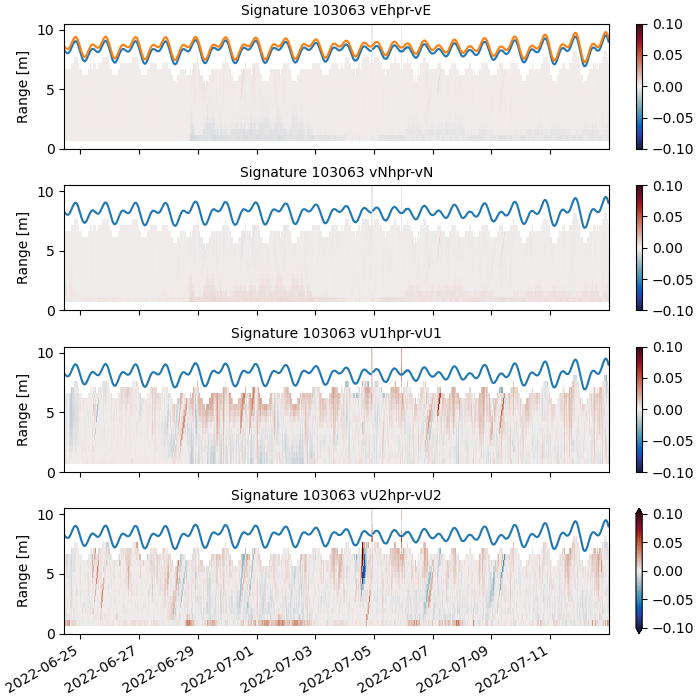

In [7]:
# Initialize figure
fig, axes = plt.subplots(figsize=(7,7), nrows=4, sharex=True, sharey=True,
                         constrained_layout=True)
vmin = -0.1
vmax = 0.1
fontsize = 10
# diff of vE on top
(ds.vEhpr - ds.vE).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[0], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vEhpr-vE')
ds.ASTd.plot(ax=axes[0], label='ASTd') # Include mean AST surface signal
ds.z_lin.plot(ax=axes[0], label='z_lin') # Include mean AST surface signal
axes[0].set_title('Signature {} vEhpr-vE'.format(ser), fontsize=fontsize)
# diff of vN in middle
(ds.vNhpr - ds.vN).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[1], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vNhpr-vN')
ds.ASTd.plot(ax=axes[1], label='ASTd') # Include mean AST surface signal
axes[1].set_title('Signature {} vNhpr-vN'.format(ser), fontsize=fontsize)
# diff of vU1 in middle
(ds.vU1hpr - ds.vU1).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[2], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vU1hpr-vU1')
ds.ASTd.plot(ax=axes[2], label='ASTd') # Include mean AST surface signal
axes[2].set_title('Signature {} vU1hpr-vU1'.format(ser), fontsize=fontsize)
# diff of vU2 on bottom
(ds.vU2hpr - ds.vU2).where(ds.range<=ds.vel_binh).plot.pcolormesh(ax=axes[3], x='time', 
    y='range', vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, label='vU2hpr-vU2')
ds.ASTd.plot(ax=axes[3], label='ASTd') # Include mean AST surface signal
axes[3].set_title('Signature {} vU2hpr-vU2'.format(ser), fontsize=fontsize)

# Set axis labels and limits
for ax in axes:
    ax.set_ylim([0,ds.ASTd.max().values+1.0])
    ax.set_xlabel('')
    ax.set_ylabel('Range [m]')

plt.show()
# plt.clf()

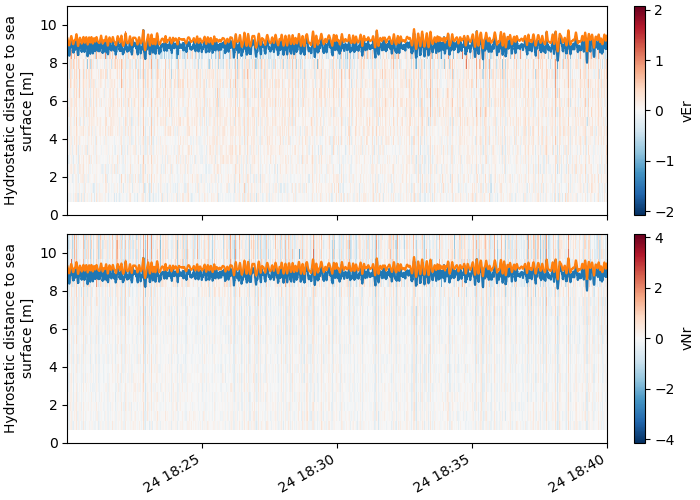

In [10]:
def DoRotation(u, v, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([u, v]))

# Read 2022-07-07 dataset and plot
fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[0], decode_coords='all'))

# Rotate E/N velocities to local coordinates
u = dsi.vE.values
v = dsi.vN.values
angle_met = 270 - 293 + 12.88
angle_math = (270 - angle_met) # Convert to math conv.
if angle_math < 0:
    angle_math += 360
angle_math = np.deg2rad(angle_math)
ul, vl = DoRotation(u, v, angle_math)
dsi['vEr'] = (['time', 'range'], ul)
dsi['vNr'] = (['time', 'range'], vl)

# Plot specified time period
t0 = pd.Timestamp('2022-06-24 18:20:00')
t1 = pd.Timestamp('2022-06-24 18:40:00')
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True, sharey=True, 
                         constrained_layout=True)
# dsi.sel(time=slice(t0, t1)).vEhpr.plot.pcolormesh(x='time', y='range', ax=axes[0], 
#                                                   label='vEhpr')
dsi.sel(time=slice(t0, t1)).vEr.where(dsi.range<dsi.ASTd).plot.pcolormesh(x='time', y='range', 
    ax=axes[0], label='vEhpr')

dsi.sel(time=slice(t0, t1)).ASTd.plot(ax=axes[0])
dsi.sel(time=slice(t0, t1)).z_hyd.plot(ax=axes[0])
dsi.sel(time=slice(t0, t1)).vNr.plot.pcolormesh(x='time', y='range', ax=axes[1], 
                                                  label='vNhpr')
dsi.sel(time=slice(t0, t1)).ASTd.plot(ax=axes[1])
dsi.sel(time=slice(t0, t1)).z_hyd.plot(ax=axes[1])
for ax in axes:
    ax.set_ylim([0,dsi.ASTd.max()+1.0])
    ax.set_xlabel(None)

plt.show()


